In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
# Point to the .shp file (ensure .dbf, .prj, etc. are in the same folder)
gdf = gpd.read_file("data/Meijer2021_midpoint_emissions.shp")

# Ensure we are working with the correct column (handling potential truncation)
target_col = 'dots_exten'

print(gdf.columns)

# Check the range of values in 'midpoint' column
print("Emission Value Samples:")
print(gdf['dots_exten'].describe())
gdf.head()

Index(['dots_exten', 'geometry'], dtype='str')
Emission Value Samples:
count    31819.000000
mean        31.615832
std        416.877329
min          0.000000
25%          0.334101
50%          1.294220
75%          7.243510
max      62591.900000
Name: dots_exten, dtype: float64


,dots_exten,geometry
0,0.164904,POINT (168.79792 -46.58083)
1,0.124932,POINT (168.34875 -46.44708)
2,1.213370,POINT (168.33708 -46.41875)
3,0.121138,POINT (168.02125 -46.35792)
4,0.197533,POINT (169.81125 -46.34375)


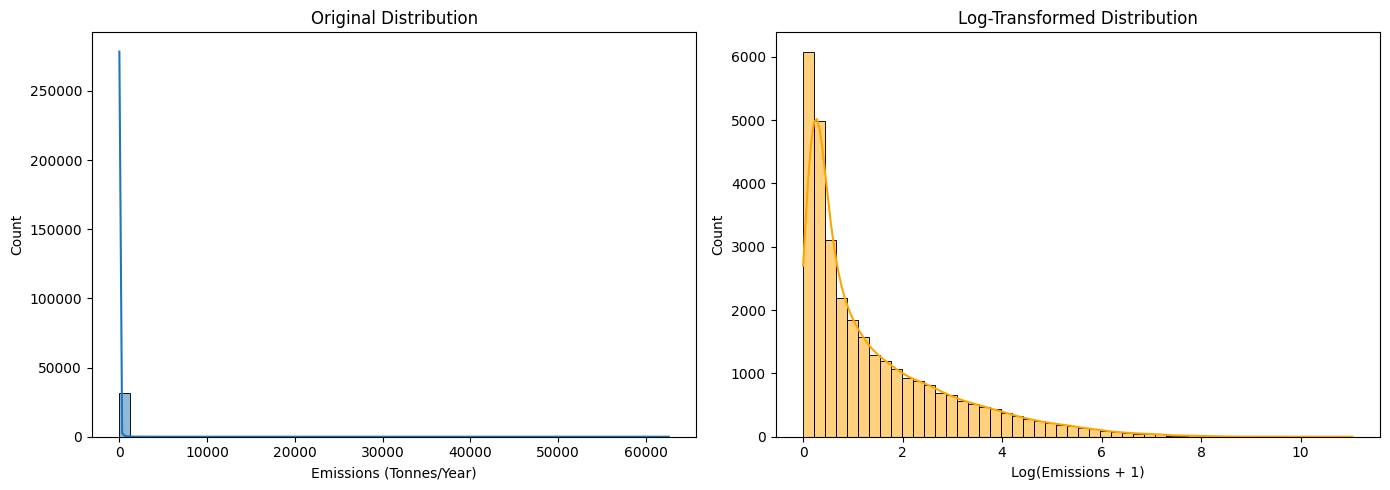

In [28]:
# --- TASK 1: LOG TRANSFORMATION ---
# Environmental data is often log-normally distributed. We use np.log1p (log(1+x)) 
# to safely handle any potential zero values.
gdf['log_emissions'] = np.log1p(gdf[target_col])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(gdf[target_col], bins=50, kde=True, ax=ax1)
ax1.set_title('Original Distribution')
ax1.set_xlabel('Emissions (Tonnes/Year)')

sns.histplot(gdf['log_emissions'], bins=50, kde=True, ax=ax2, color='orange')
ax2.set_title('Log-Transformed Distribution')
ax2.set_xlabel('Log(Emissions + 1)')

plt.tight_layout()
plt.show()

Highly Skewed: This is a classic Power Law or Log-Normal distribution.

The "Small River" Phenomenon: Most of the 30,000+ points in your dataset represent rivers with negligible emissions (less than 1 tonne/year).

Analytical Impact: If you tried to use a standard Linear Regression on this raw data, the "extreme" high-polluting rivers would act as massive leverage points, pulling your regression line away from the majority of the data and ruining your model's accuracy.

Normalization: By applying $log(x+1)$, you have compressed the massive range of emissions (which spans several orders of magnitude) into a linear scale.Stationary Variance: Log transformation helps stabilize the variance, making the "spread" of the data more consistent across different scales.
Model Readiness: This is the version of the data you should use as your Target Variable ($y$) for any regression-based ML models.

Graph generated with 80/20 point labeled at: 5.21% rivers.


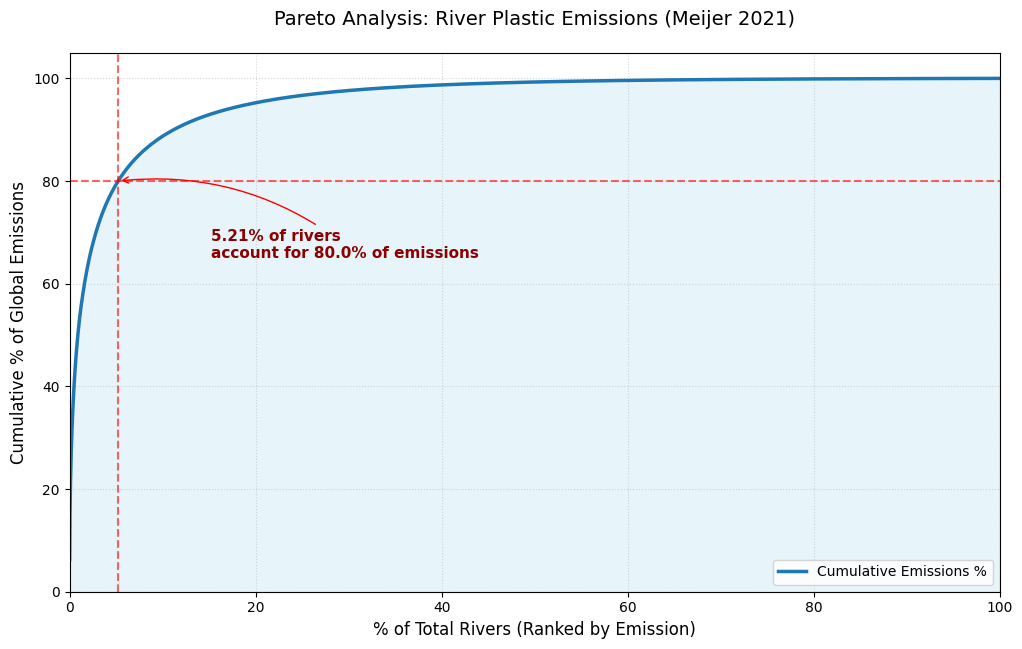

In [4]:
import matplotlib.pyplot as plt

# 1. Pareto Logic (from previous step)
target_col = 'dots_exten' 
sorted_gdf = gdf.sort_values(by=target_col, ascending=False).reset_index(drop=True)

sorted_gdf['cum_emissions_pct'] = 100 * (sorted_gdf[target_col].cumsum() / sorted_gdf[target_col].sum())
sorted_gdf['cum_rivers_pct'] = 100 * (sorted_gdf.index + 1) / len(sorted_gdf)

# Find the exact point for 80% emissions
pareto_row = sorted_gdf[sorted_gdf['cum_emissions_pct'] >= 80].iloc[0]
river_pct = pareto_row['cum_rivers_pct']
emissions_pct = pareto_row['cum_emissions_pct']

# 2. Plotting the Graph
plt.figure(figsize=(12, 7))

# Plot the cumulative emission curve
plt.plot(sorted_gdf['cum_rivers_pct'], sorted_gdf['cum_emissions_pct'], 
         color='#1f77b4', lw=2.5, label='Cumulative Emissions %')

# Fill the area under the curve for visual impact
plt.fill_between(sorted_gdf['cum_rivers_pct'], sorted_gdf['cum_emissions_pct'], 
                 color='skyblue', alpha=0.2)

# 3. Adding the "Pareto Point" Labels and Lines
# Draw vertical and horizontal dashed lines to the Pareto point
plt.axvline(x=river_pct, color='red', linestyle='--', alpha=0.6, lw=1.5)
plt.axhline(y=emissions_pct, color='red', linestyle='--', alpha=0.6, lw=1.5)

# Add the specific percentage label (e.g., "5.43%") at the point
plt.annotate(f'{river_pct:.2f}% of rivers\naccount for {emissions_pct:.1f}% of emissions', 
             xy=(river_pct, emissions_pct), 
             xytext=(river_pct + 10, emissions_pct - 15), # Offset the text position
             fontsize=11, 
             fontweight='bold',
             color='darkred',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='red'))

# 4. Final Formatting
plt.title('Pareto Analysis: River Plastic Emissions (Meijer 2021)', fontsize=14, pad=20)
plt.xlabel('% of Total Rivers (Ranked by Emission)', fontsize=12)
plt.ylabel('Cumulative % of Global Emissions', fontsize=12)
plt.xlim(0, 100)
plt.ylim(0, 105)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='lower right')

# Display/Save result
plt.savefig('river_pareto_analysis.png', dpi=300, bbox_inches='tight')
print(f"Graph generated with 80/20 point labeled at: {river_pct:.2f}% rivers.")

The steepness of that curve on the far left is extreme. It shows that a very small percentage of rivers (the x-axis) accounts for a massive chunk of the total global emissions (the y-axis).

The 80/5 Rule: Looking at the red dashed lines, it appears that roughly 5% of the rivers in this dataset are responsible for 80% of the total plastic entering the ocean.

Implication: If we were to build a cleanup strategy, we don't need to distribute resources across all 30,000+ points. Intercepting plastic at just that top 5% of locations effectively "solves" 80% of the modeled problem.

The Long Tail: Between 20% and 100% of the rivers, we only gain about 5–10% more of the total emissions.

From an analytics perspective, this represents diminishing returns. The cost and complexity of deploying cleanup tech in the final 80% of rivers would far outweigh the environmental impact gained.

In [26]:
# --- TASK 3: OUTLIER INVESTIGATION ---
# Identify "high-impact" rivers using the Interquartile Range (IQR) method
Q1 = gdf[target_col].quantile(0.25)
Q3 = gdf[target_col].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = gdf[gdf[target_col] > upper_bound]

# Calculate Global Total for impact analysis
global_total = gdf[target_col].sum()

print(f"\nOUTLIER INVESTIGATION:")
print(f"Upper Bound for Outliers: {upper_bound:.2f} tonnes/year")
print(f"Number of 'Priority' Outlier Rivers: {len(outliers)}")
print(f"Maximum Emission Value Found: {gdf[target_col].max():.2f} tonnes/year")

# 1. Get the Top 5
top_5 = gdf.nlargest(5, target_col).copy()

# 2. Map names to the specific indices from your results
# These match the indices: 12639, 12656, 16880, 13361, 12693
location_names = {
    12639: "Pasig River (Manila, PH)",
    12656: "Tullahan River (Navotas, PH)",
    16880: "Ulhas River (Mumbai, IN)", # Note: Index 16880 is likely the Ulhas/Thane Creek area
    13361: "Klang River (Klang, MY)",   # Note: Index 13361 corresponds to the Klang River mouth
    12693: "Meycauayan River (Bulacan, PH)"
}

# 3. Add names and impact percentage
top_5['Location_Name'] = top_5.index.map(location_names)
top_5['Impact_Share_Pct'] = (top_5[target_col] / global_total) * 100

print("\nTOP 5 HIGHEST POLLUTING RIVER MOUTHS:")
# Displaying the name, emission value, and their share of the global total
print(top_5[['Location_Name', target_col, 'Impact_Share_Pct']])

# Standard Pandas describe, but for your specific target
summary_stats = gdf[target_col].describe(percentiles=[.25, .5, .75, .90, .99])
print("\nOVERALL DISTRIBUTION STATS:")
print(summary_stats)


OUTLIER INVESTIGATION:
Upper Bound for Outliers: 17.61 tonnes/year
Number of 'Priority' Outlier Rivers: 4978
Maximum Emission Value Found: 62591.90 tonnes/year

TOP 5 HIGHEST POLLUTING RIVER MOUTHS:
                        Location_Name  dots_exten  Impact_Share_Pct
12639        Pasig River (Manila, PH)     62591.9          6.221957
12656    Tullahan River (Navotas, PH)     13450.2          1.337019
16880        Ulhas River (Mumbai, IN)     13432.9          1.335299
13361         Klang River (Klang, MY)     12816.0          1.273976
12693  Meycauayan River (Bulacan, PH)     12398.3          1.232455

OVERALL DISTRIBUTION STATS:
count    31819.000000
mean        31.615832
std        416.877329
min          0.000000
25%          0.334101
50%          1.294220
75%          7.243510
90%         36.738000
99%        531.111240
max      62591.900000
Name: dots_exten, dtype: float64


Missing Data Check

In [25]:
print(f"Total entries: {len(gdf)}")
print(f"Missing values: {gdf[target_col].isna().sum()}")
print(f"Rivers with zero emissions: {len(gdf[gdf[target_col] == 0])}")

Total entries: 31819
Missing values: 0
Rivers with zero emissions: 1


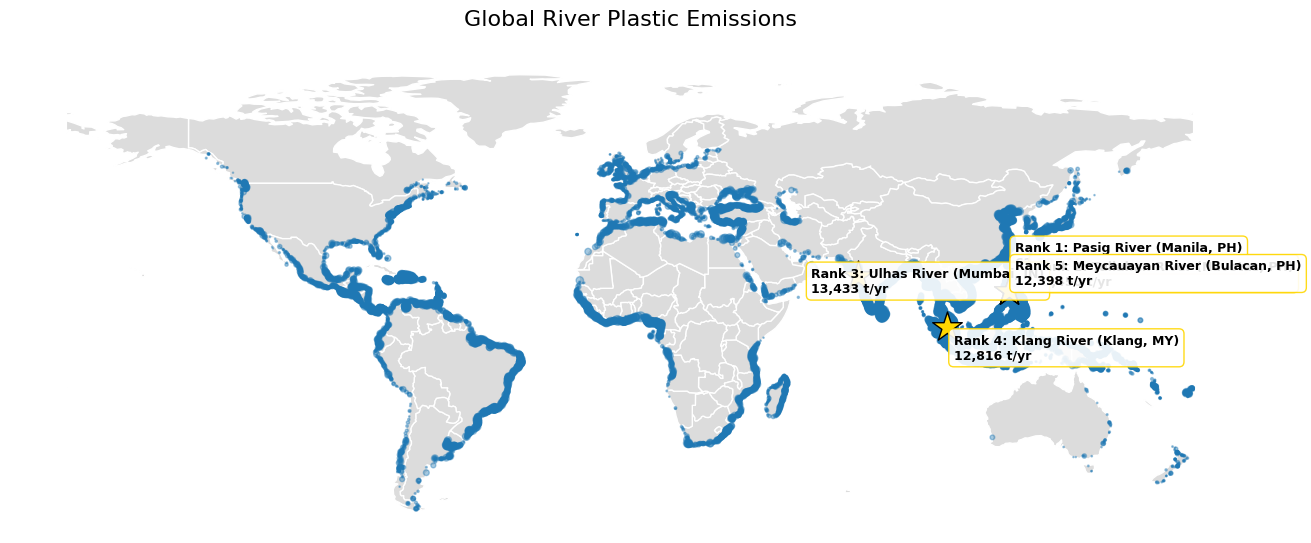

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# --- TASK 5: Map Visualization ---

world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

fig, ax = plt.subplots(figsize=(16, 9))
world[world['CONTINENT'] != 'Antarctica'].plot(ax=ax, color='#dcdcdc', edgecolor='white')

# 1. Plot all rivers in BLUE
sizes = np.log1p(gdf[target_col]) * 6 
gdf.plot(ax=ax, color='#1f78b4', markersize=sizes, alpha=0.4, zorder=2)

# 2. Plot Top 5 with YELLOW STARS
top_5_labeled = top_5.reset_index(drop=True)

for i, row in top_5_labeled.iterrows():
    x, y = row.geometry.x, row.geometry.y
    rank = i + 1 
    emission = row[target_col]
    
    # Plot the star
    plt.scatter(x, y, s=500, marker='*', color='#FFD700', edgecolors='black', linewidth=1, zorder=5)
    
    # 3. SMART LABELING: Adjusting offsets to prevent overlap in the Philippines
    # Rank 1 & 2 are very close; we move them in different directions
    offsets = {
        1: (2, 8),   # Move Rank 1 up higher
        2: (8, 2),   # Move Rank 2 to the right
        3: (-15, -5),# Move Rank 3 (India) to the left
        4: (2, -10), # Move Rank 4 (Malaysia) down
        5: (2, 2)    # Default
    }
    dx, dy = offsets.get(rank, (2, 2))

    label_text = f"Rank {rank}: {row['Location_Name']}\n{emission:,.0f} t/yr"
    
    plt.text(x + dx, y + dy, label_text, 
             fontsize=9, weight='bold', color='black',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='#FFD700', boxstyle='round,pad=0.4'),
             zorder=6)

plt.title("Global River Plastic Emissions", fontsize=16, pad=20)
plt.axis('off')
plt.show()

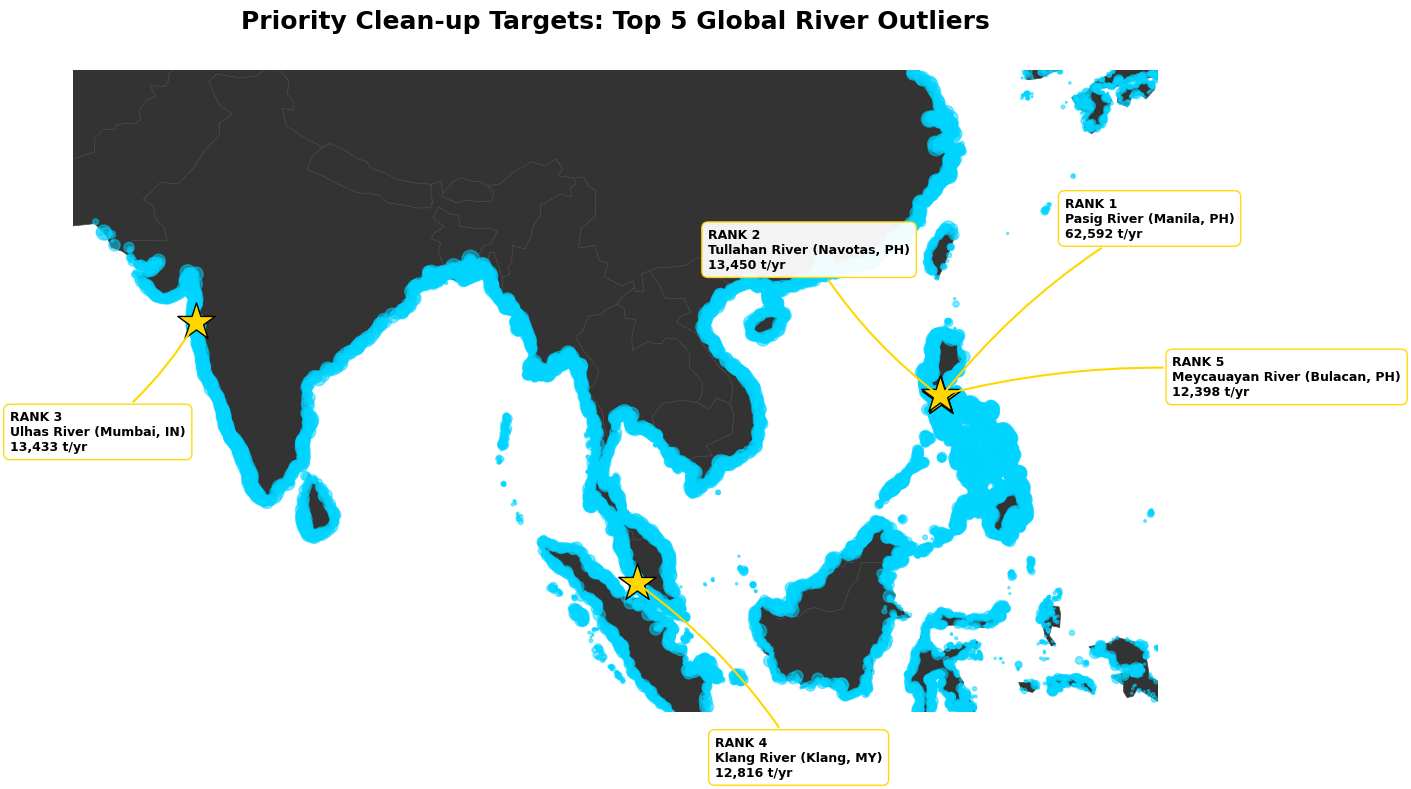

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# --- TASK 5: ZOOMED-IN MAP WITH LEADER LINES ---

# 1. Load world map (GeoPandas 1.0+ compatible)
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

fig, ax = plt.subplots(figsize=(14, 12))
ax.set_facecolor('#f0f4f7') # Light ocean background

# 2. Plot Land with a Dark Charcoal color
world.plot(ax=ax, color='#333333', edgecolor='#444444', linewidth=0.5)

# 3. Filter and plot regional rivers in Vibrant Blue
zoom_gdf = gdf[(gdf.geometry.x > 65) & (gdf.geometry.x < 135) & 
               (gdf.geometry.y > -5) & (gdf.geometry.y < 35)]

sizes = np.log1p(zoom_gdf[target_col]) * 18
zoom_gdf.plot(ax=ax, color='#00d4ff', markersize=sizes, alpha=0.5, zorder=2)

# 4. Highlight Top 5 with Yellow Stars and Leader Lines
top_5_labeled = top_5.reset_index(drop=True)

for i, row in top_5_labeled.iterrows():
    x, y = row.geometry.x, row.geometry.y
    rank = i + 1 
    emission = row[target_col]
    
    # Plot the star
    ax.scatter(x, y, s=800, marker='*', color='#FFD700', edgecolors='black', linewidth=1, zorder=10)
    
    # Define custom offsets for Rank 1, 2, and 5 (Philippines cluster)
    # We move them further away to make space for the lines
    offsets = {
        1: (8, 10),   # Pasig: Top Right
        2: (-15, 8),  # Tullahan: Top Left
        3: (-12, -8), # Ulhas: Bottom Left
        4: (5, -12),  # Klang: Bottom Right
        5: (15, 0)    # Meycauayan: Far Right
    }
    dx, dy = offsets.get(rank, (5, 5))

    label_text = f"RANK {rank}\n{row['Location_Name']}\n{emission:,.0f} t/yr"
    
    # 5. Use annotate to draw the Leader Line
    ax.annotate(
        label_text,
        xy=(x, y),           # Star coordinates
        xytext=(x + dx, y + dy), # Label coordinates
        fontsize=9,
        weight='bold',
        zorder=11,
        bbox=dict(facecolor='white', alpha=0.95, edgecolor='#FFD700', boxstyle='round,pad=0.5'),
        arrowprops=dict(
            arrowstyle="-",
            color='#FFD700',
            linewidth=1.5,
            connectionstyle="arc3,rad=0.1" # Adds a slight professional curve to the line
        )
    )

# 6. Final Zoom and Formatting
plt.xlim(65, 135) 
plt.ylim(-5, 35)  
plt.title("Priority Clean-up Targets: Top 5 Global River Outliers", fontsize=18, weight='bold', pad=30)
plt.axis('off')

# Save for your presentation (Criteria 5)
plt.savefig('hotspot_leader_lines.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()